# Import hail and setup notebook

In [1]:
import hail as hl
import pandas as pd
import numpy as np
print("Hail version: " + hl.version())
hl.init(spark_conf={ "spark.master": "local[16]", "spark.driver.memory": "30g" })
# hl.spark_context().getConf().getAll()

Hail version: 0.2.61-3c86d3ba497a


Running on Apache Spark version 2.4.1
SparkUI available at http://ouga02.cmm.in.tum.de:4040
Welcome to
     __  __     <>__
    / /_/ /__  __/ /
   / __  / _ `/ / /
  /_/ /_/\_,_/_/_/   version 0.2.61-3c86d3ba497a
LOGGING: writing to /data/nasif12/home_if12/mertes/projects/ALS/notebooks/hail-20210511-1102-0.2.61-3c86d3ba497a.log


In [2]:
from bokeh.io import output_notebook, show
output_notebook()

Loading BokehJS ...

# Import VCF file

In [3]:
reImport  = False
testRun   = False
vcfFile   = "/s/raw/als/kaggle/end-als/genomics-data/AnswerALS_subset_annovar.hg38_anno_and_geno.no_intergenic.vcf.gz"
vcfMtFile = "/s/project/kaggle-als/hail/AnswerALS_subset_annovar.hg38_anno_and_geno.no_intergenic"
relatenessTableFile = "/s/project/kaggle-als/sample_relateness.tsv"

In [4]:
ref_genome = hl.get_reference('GRCh38')
if reImport is True:
    hl.import_vcf(vcfFile, force_bgz=True, reference_genome=ref_genome).write(vcfMtFile, overwrite=True)

In [5]:
mt = hl.read_matrix_table(vcfMtFile)
# mt.describe()

In [6]:
mt_biallelic = mt.filter_rows(hl.len(mt.alleles) == 2)

In [7]:
print(mt.count_cols())
print(mt.count_rows())
print(mt_biallelic.count_rows())

153
10945502
10029506


In [8]:
mt_bi_n_common = mt_biallelic.filter_rows((mt_biallelic.info.AF > [0.01]) & (mt_biallelic.info.AF < [0.95]) & (mt_biallelic.info.AN > 200.0))
if testRun is True:
    mt_bi_n_common = mt_bi_n_common.filter_rows(mt_bi_n_common.locus.contig == 'chr21')
print(mt_bi_n_common.count_rows())

4559359


## Compute identity by descent (IBD) using PLINK
For more info refer to https://hail.is/docs/0.2/methods/relatedness.html#relatedness

In [9]:
# compute IBD on the subsetted bi allelic variants
ibd = hl.identity_by_descent(mt_bi_n_common)

In [10]:
# export table to DataFrame
df_ibd = ibd.to_pandas()
df_ibd

2021-05-11 11:10:18 Hail: INFO: Coerced sorted dataset


,i,j,ibd.Z0,ibd.Z1,ibd.Z2,ibd.PI_HAT,ibs0,ibs1,ibs2
0,CGND-HDA-00187-b38,CGND-HDA-00202-b38,1.000000,0.000000,0.000000,0.000000,202231,1339233,2997454
1,CGND-HDA-00187-b38,CGND-HDA-00203-b38,1.000000,0.000000,0.000000,0.000000,194362,1360274,2983446
2,CGND-HDA-00187-b38,CGND-HDA-00204-b38,1.000000,0.000000,0.000000,0.000000,205802,1331838,3000928
3,CGND-HDA-00187-b38,CGND-HDA-00206-b38,1.000000,0.000000,0.000000,0.000000,195886,1339778,3002231
4,CGND-HDA-00187-b38,CGND-HDA-00207-b38,1.000000,0.000000,0.000000,0.000000,209578,1318023,3010822
...,...,...,...,...,...,...,...,...,...
11623,CGND-HDA-03519,CGND-HDA-03736,0.981092,0.004261,0.014648,0.016778,183037,1342943,3008577
11624,CGND-HDA-03519,CGND-HDA-03801,1.000000,0.000000,0.000000,0.000000,190321,1327265,3016246
11625,CGND-HDA-03579,CGND-HDA-03736,1.000000,0.000000,0.000000,0.000000,192583,1343898,2996661
11626,CGND-HDA-03579,CGND-HDA-03801,1.000000,0.000000,0.000000,0.000000,196194,1318016,3018357


Compute relateness based on the cutoffs giving here: [DOI: 10.1534/genetics.117.1122](https://www.genetics.org/content/genetics/suppl/2017/07/21/genetics.117.1122.DC1/FileS1.pdf)

In [11]:
# the cutoffs for PI_HAT
relateness_cuts = pd.DataFrame(data={
    "cuts_PI_HAT": np.concatenate((1/(2**(np.array([0,3,5,7,9,11,13,15,17])/2)), np.array([0.0]))),
    "Degree": ['0', '1', '2', '3', '4', '5', '6', '7', '8', 'None']})[::-1]
relateness_cuts

,cuts_PI_HAT,Degree
9,0.000000,None
8,0.002762,8
7,0.005524,7
6,0.011049,6
5,0.022097,5
4,0.044194,4
3,0.088388,3
2,0.176777,2
1,0.353553,1
0,1.000000,0


In [12]:
# assign degree of relateness
df_ibd['degree'] = pd.cut(df_ibd['ibd.PI_HAT'], 
                         bins=relateness_cuts['cuts_PI_HAT'].values, 
                         labels=relateness_cuts['Degree'][:-1].values,
                         right=True,
                         include_lowest=True)
df_ibd

,i,j,ibd.Z0,ibd.Z1,ibd.Z2,ibd.PI_HAT,ibs0,ibs1,ibs2,degree
0,CGND-HDA-00187-b38,CGND-HDA-00202-b38,1.000000,0.000000,0.000000,0.000000,202231,1339233,2997454,None
1,CGND-HDA-00187-b38,CGND-HDA-00203-b38,1.000000,0.000000,0.000000,0.000000,194362,1360274,2983446,None
2,CGND-HDA-00187-b38,CGND-HDA-00204-b38,1.000000,0.000000,0.000000,0.000000,205802,1331838,3000928,None
3,CGND-HDA-00187-b38,CGND-HDA-00206-b38,1.000000,0.000000,0.000000,0.000000,195886,1339778,3002231,None
4,CGND-HDA-00187-b38,CGND-HDA-00207-b38,1.000000,0.000000,0.000000,0.000000,209578,1318023,3010822,None
...,...,...,...,...,...,...,...,...,...,...
11623,CGND-HDA-03519,CGND-HDA-03736,0.981092,0.004261,0.014648,0.016778,183037,1342943,3008577,6
11624,CGND-HDA-03519,CGND-HDA-03801,1.000000,0.000000,0.000000,0.000000,190321,1327265,3016246,None
11625,CGND-HDA-03579,CGND-HDA-03736,1.000000,0.000000,0.000000,0.000000,192583,1343898,2996661,None
11626,CGND-HDA-03579,CGND-HDA-03801,1.000000,0.000000,0.000000,0.000000,196194,1318016,3018357,None


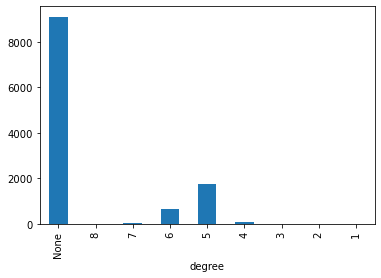

In [13]:
df_ibd.groupby('degree').count().i.plot(kind='bar')

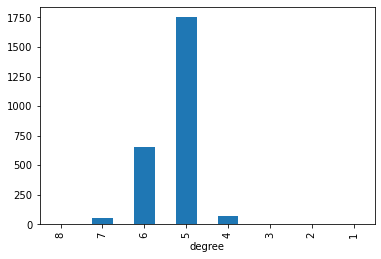

In [14]:
df_ibd.groupby('degree').count().i[1:].plot(kind='bar')

## Save table

In [15]:
print(relatenessTableFile)
df_ibd.to_csv(relatenessTableFile, sep="\t")

/s/project/kaggle-als/sample_relateness.tsv


# Use PC relate and the kinship metric

In [16]:
pc_rel = hl.pc_relate(mt_bi_n_common.GT, min_individual_maf=0.01, k=10)

2021-05-11 11:11:03 Hail: INFO: hwe_normalized_pca: running PCA using 4559359 variants.
2021-05-11 11:11:27 Hail: INFO: pca: running PCA with 10 components...
2021-05-11 11:15:35 Hail: INFO: Wrote all 1114 blocks of 4559359 x 153 matrix with block size 4096.


In [18]:
df_pcr = pc_rel.to_pandas()

ERROR:py4j.java_gateway:An error occurred while trying to connect to the Java server (127.0.0.1:43755)
Traceback (most recent call last):
  File "/opt/modules/i12g/anaconda/envs/hail-dev/lib/python3.7/site-packages/py4j/java_gateway.py", line 929, in _get_connection
    connection = self.deque.pop()
IndexError: pop from an empty deque

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/opt/modules/i12g/anaconda/envs/hail-dev/lib/python3.7/site-packages/py4j/java_gateway.py", line 1067, in start
    self.socket.connect((self.address, self.port))
ConnectionRefusedError: [Errno 111] Connection refused


Py4JNetworkError: An error occurred while trying to connect to the Java server (127.0.0.1:43755)

In [ ]:
df_pcr